### Development notebook
- Don't write new classes directly from main.py! What happens is you will need to use the debugger, which is just a shittier jupyter notebook. Better to just start from the notebook, using ssh tunnels from remote to local. Also this avoids dealing w/ sacred and wandb overhead when you don't need it
- Better to manually copy code from repo into an self-contained jupyter notebook, get it working here first, then move working code into the main repo and only use the debugger for small tweaks
- copy this notebook when writing a new class

In [17]:
# set absolute path to repo (*don't* use cd ..)
%cd /ubc/cs/research/fwood/vadmas/dev/projects/active/tvo_icml/
# put all boilerplate here
%run ./notebooks/init.ipynb


/ubc/cs/research/fwood/vadmas/dev/projects/active/tvo_icml


In [18]:
from types import SimpleNamespace
import torch

In [19]:
# set hypers here
args = SimpleNamespace()

args.learning_task = 'continuous_vae'
args.data_path = './data/mnist.pkl'
args.device = torch.device('cpu') 
args.batch_size = 1000
args.test_batch_size = 1
args.num_stochastic_layers = 1
args.num_deterministic_layers = 2
args.hidden_dim = 100 
args.latent_dim = 25
args.learn_prior = False
args.loss = 'tvo'
args.activation = torch.nn.ReLU()
args.integration = "trapz"
args.K = 7
args.S = 10
args.lr = 0.001
args.log_beta_min = -1.602
args.schedule = 'log'

In [20]:
# import whatever you need from src

In [21]:
from src.data_handler import StochasticMNIST, make_continuous_vae_data

In [22]:
# get data
train_data_loader, test_data_loader = make_continuous_vae_data(args)
args.train_data_loader = train_data_loader
args.test_data_loader = test_data_loader


In [23]:
# for example, to write a new VAE class I would  copy the code here:

In [24]:
from src.models.vaes import VAEBaseClass

In [25]:
from src.models.base import ProbModelBaseClass
from src.models.mlp import init_mlp, init_two_prong_mlp
import torch
from torch.distributions import Independent
import torch.nn as nn
from src import util


In [26]:
class ContinuousVAE(VAEBaseClass):
    def __init__(self, D, args):
        super().__init__(D, args)
        if self.args.learn_prior:
            print("Learning prior")
            self.decoder_latent_param_mu = nn.Parameter(torch.zeros(
                self.latent_dims[0], device=self.args.device, dtype=torch.float))
            self.decoder_latent_param_sig = nn.Parameter(torch.ones(
                self.latent_dims[0], device=self.args.device, dtype=torch.float))
        else:
            self.decoder_latent_param_mu = torch.zeros(
                self.latent_dims[0], device=self.args.device, dtype=torch.float)
            self.decoder_latent_param_sig = torch.ones(
                self.latent_dims[0], device=self.args.device, dtype=torch.float)

        self.layer_0_params = (self.decoder_latent_param_mu,
                               self.decoder_latent_param_sig)

        self.decoders = nn.ModuleDict()
        for i in range(1, self.num_stochastic_layers):
            self.decoders[str(i)] = init_two_prong_mlp(in_dim=self.latent_dims[i - 1],
                                                       out_dim=self.latent_dims[i],
                                                       hidden_dim=self.hidden_dim,
                                                       num_layers=self.num_deterministic_layers,
                                                       non_linearity=self.activation)

        # This is the mlp from discrete.py that doesn't produce a sigma
        self.decoder_to_obs = init_mlp(in_dim=self.latent_dims[-1],
                                       out_dim=self.D,
                                       hidden_dim=self.hidden_dim,
                                       num_layers=self.num_deterministic_layers,
                                       non_linearity=self.activation)

        self.encoder_to_obs = init_two_prong_mlp(in_dim=self.D,
                                                 out_dim=self.latent_dims[-1],
                                                 hidden_dim=self.hidden_dim,
                                                 num_layers=self.num_deterministic_layers,
                                                 non_linearity=self.activation)

        self.encoders = nn.ModuleDict()
        for i in reversed(range(self.num_stochastic_layers - 1)):
            self.encoders[str(i)] = init_two_prong_mlp(in_dim=self.latent_dims[i + 1],
                                                       out_dim=self.latent_dims[i],
                                                       hidden_dim=self.hidden_dim,
                                                       num_layers=self.num_deterministic_layers,
                                                       non_linearity=self.activation)

In [27]:
# get your model
D = train_data_loader.dataset.image.shape[1]
model = ContinuousVAE(D, args)

Reparam turned: OFF


In [28]:
# get a single datapoint (no need to write a training loop)

In [29]:
data=next(iter(train_data_loader))

In [30]:
# manually set internals
model.set_internals(data)

In [31]:
# now do something

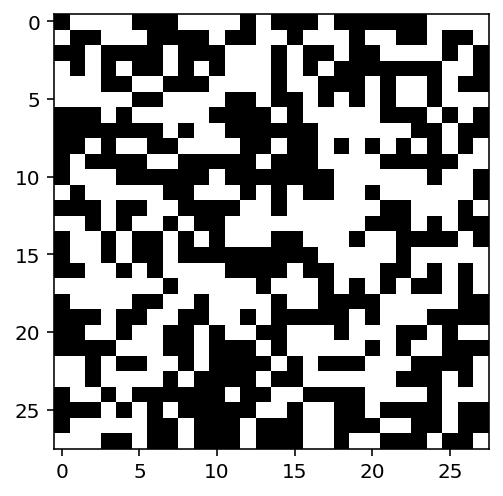

In [32]:
# plot
plt.imshow(model.sample_model_obs().numpy().reshape((28, 28)), cmap='gray')
plt.show()